# the easiest setting with Q table, $\pi=0$, 

In [1]:
import joblib
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor


In [ ]:
from numpy.ma.core import exp
# define some functions to generate the simulation data

def generate_S0(n0):
    return np.random.binomial(1,0.5,size=n0)

def generate_Ut(n0):
    return np.random.binomial(1,0.5,size=n0)
    #return (np.random.binomial(size=n0, n=1, p= 0.5)-0.5)*2

def generate_Zt(St,n0):
    dt=0.25*np.random.binomial(1,0.5,size=n0)
    p=1/(1+exp(-(St+dt-2))).data
    return np.random.binomial(1,p,size=n0)

def generate_At(St,Zt,Ut,n0):
    p=1/(1+exp(-(St+2*Zt+0.25*Ut-2))).data
    return np.random.binomial(1,p,size=n0)

def generate_Rt(St,At,Ut,n0):
    p=1/(1+exp(-(St+At+Ut-2))).data
    return 10*np.random.binomial(1,p,size=n0)

def generate_Stplus1(St,At,Ut,n0):
    p=1/(1+exp(-(St+At+Ut-2))).data
    return np.random.binomial(1,p,size=n0)


In [ ]:
# the number of samples
n0=10**5
# the number of stages
T=100

# S0\sim Ber(0.5), At=0 (Pi=0)
np.random.seed(528)
S0=np.random.binomial(1,0.5,n0)
MDP0 = np.copy(S0)
St=S0
for i in range(T):
    Ut=generate_Ut(n0)
    Zt=generate_Zt(St,n0)
    At=np.zeros(n0)
    Rt=generate_Rt(St,At,Ut,n0)
    Stplus1=generate_Stplus1(St,At,Ut,n0)
    MDP0 = np.vstack((MDP0, Zt, At, Rt, Stplus1))
    St=Stplus1

MDP0=MDP0.T

print(np.shape(MDP0))



(100000, 401)


In [ ]:
pd.DataFrame(MDP0)

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,10.0,1.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,1.0
99997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0
99998,1.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sum(MDP0[:,400])/n0

0.23796

In [ ]:
gamma=0.9


n0=10**5
# the number of stages
T=100

# S0=1, At=0 (Pi=0)
np.random.seed(528)
S0=np.ones(n0)
MDP0_S1 = np.copy(S0)
St=S0
for i in range(T):
    Ut=generate_Ut(n0)
    Zt=generate_Zt(St,n0)
    At=np.zeros(n0)
    Rt=generate_Rt(St,At,Ut,n0)
    Stplus1=generate_Stplus1(St,At,Ut,n0)
    MDP0_S1 = np.vstack((MDP0_S1, Zt, At, Rt, Stplus1))
    St=Stplus1

MDP0_S1=MDP0_S1.T

print(np.shape(MDP0_S1))
# true value of $V^{\pi=0}(S_0=1)$ can be estimated by
V_pi0_S1=0

for t in range(T):
    V_pi0_S1=V_pi0_S1+(gamma**(t))*sum(MDP0_S1[:,3+4*t])/n0

V_pi0_S1

(100000, 401)


25.737206028752162

In [ ]:
gamma=0.9


n0=10**5
# the number of stages
T=100

# S0=0, At=0 (Pi=0)
np.random.seed(528)
S0=np.zeros(n0)
MDP0_S0 = np.copy(S0)
St=S0
for i in range(T):
    Ut=generate_Ut(n0)
    Zt=generate_Zt(St,n0)
    At=np.zeros(n0)
    Rt=generate_Rt(St,At,Ut,n0)
    Stplus1=generate_Stplus1(St,At,Ut,n0)
    MDP0_S0 = np.vstack((MDP0_S0, Zt, At, Rt, Stplus1))
    St=Stplus1

MDP0_S0=MDP0_S0.T

print(np.shape(MDP0_S0))
# true value of $V^{\pi=0}(S_0=1)$ can be estimated by
V_pi0_S0=0

for t in range(T):
    V_pi0_S0=V_pi0_S0+(gamma**(t))*sum(MDP0_S0[:,3+4*t])/n0

V_pi0_S0

(100000, 401)


23.45211980255217

In [ ]:

# the number of samples
n=10**3
# the number of stages
T=100

np.random.seed(525)
S0=generate_S0(n)
MDP = np.copy(S0)
St=S0
for i in range(T):
    Ut=generate_Ut(n)
    Zt=generate_Zt(St,n)
    At=generate_At(St,Zt,Ut,n)
    Rt=generate_Rt(St,At,Ut,n)
    Stplus1=generate_Stplus1(St,At,Ut,n)
    MDP = np.vstack((MDP, Zt, At, Rt, Stplus1))
    St=Stplus1

MDP=MDP.T

print(np.shape(MDP))



(1000, 401)


In [ ]:
pd.DataFrame(MDP)

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,1,0,0,10,1,1,1,10,1,1,...,10,1,1,1,10,0,0,0,0,0
1,0,0,0,10,1,1,1,10,1,1,...,0,1,0,0,0,1,0,1,0,1
2,1,0,0,0,1,0,0,0,1,0,...,10,0,0,0,0,1,1,1,10,0
3,0,0,0,0,0,0,1,0,0,1,...,10,0,0,0,0,0,0,0,10,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,10,0,0,0,10,1,0,...,0,0,0,0,0,0,0,0,10,1
998,1,0,0,10,0,0,0,0,0,0,...,0,0,0,0,10,1,0,0,10,0


In [ ]:
index_S=np.linspace(0,T-1,T)*4
index_Z=np.linspace(0,T-1,T)*4+1
index_A=np.linspace(0,T-1,T)*4+2
index_R=np.linspace(0,T-1,T)*4+3
index_SZ=np.concatenate((index_S,index_Z))
index_Splus1=np.linspace(0,T-1,T)*4+4

MDP_SZ=MDP[:,index_SZ.astype(int)]
MDP_A=MDP[:,index_A.astype(int)]

Svec=MDP[:,index_S.astype(int)].T.reshape(-1,1)
Zvec=MDP[:,index_Z.astype(int)].T.reshape(-1,1)
SZvec=np.hstack((Svec,Zvec))
Avec=MDP[:,index_A.astype(int)].T.reshape(-1,1)
Rvec=MDP[:,index_R.astype(int)].T.reshape(-1,1)

Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(-1,1)


In [ ]:
np.shape(SZvec)

(100000, 2)

### estimated models

In [ ]:
# learn Pa(St,Zt) by GBDT

A_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
A_model.fit(SZvec[range(90000)], Avec[range(90000)].reshape(1,-1)[0])
#A_model.fit(np.hstack((Svec,Zvec,Svec**2))[range(1800)], Avec[range(1800)].reshape(1,-1)[0])


GradientBoostingClassifier(max_depth=5, n_estimators=20)

In [ ]:
# accuracy of the classifier
A_model.score(SZvec[range(90000,100000)], Avec[range(90000,100000)], sample_weight=None)
#A_model.score(np.hstack((Svec,Zvec,Svec**2))[range(1800,2000)], Avec[range(1800,2000)], sample_weight=None)
# the result is actually quite good!


0.7912

In [ ]:
# estimate p11(St)
def Pa(St,Zt,n,A_model):
  if ((n==1) and (np.shape(St)==())):
    return A_model.predict_proba(np.array([St,Zt]).reshape(1, -1))[0]
  elif ((n==1) and (np.shape(St)!=())):
    return A_model.predict_proba(np.concatenate((St,np.array([Zt]))).reshape(1, -1))[0]
  else:
    return A_model.predict_proba(np.hstack((St,Zt)))

def P11(St,n,A_model):
  if (n==1):
    return Pa(St,1,n,A_model)[1]
  else:
    return Pa(St,np.ones(n).reshape(-1,1),n,A_model)[:,1]

def P10(St,n,A_model):
  if (n==1):
    return Pa(St,0,n,A_model)[1]
  else:
    return Pa(St,np.zeros(n).reshape(-1,1),n,A_model)[:,1]


def c(Zt,St,n,Pi,A_model):
  if (n==1):
    c=Zt*((Pi-P10(St,n,A_model))/(P11(St,n,A_model)-P10(St,n,A_model)))+(1-Zt)*((P11(St,n,A_model)-Pi)/(P11(St,n,A_model)-P10(St,n,A_model)))
    return c
  else:
    c=Zt.T*((Pi-P10(St,n,A_model))/(P11(St,n,A_model)-P10(St,n,A_model)))+(1-Zt.T)*((P11(St,n,A_model)-Pi)/(P11(St,n,A_model)-P10(St,n,A_model)))
    return c[0]
#from scipy.interpolate import BSpline

# Q function: a linear function of (St,Zt,At). Can be modified later.

def V(St, n, Pi, Q_table, domain_Zt, domain_At, A_model):
  len_Zt=len(domain_Zt)
  len_At=len(domain_At)
  if (n==1):
    V_St=0
    for i in range(len_Zt):
      for j in range(len_At):
        V_St=V_St+c(domain_Zt[i],St,n,Pi,A_model)*Pa(St,domain_Zt[i],n,A_model)[j]*Q_table[St,i,j]
        #V_St=V_St+c(domain_Zt[i],St,n,Pi,A_model)*Pa(St,domain_Zt[i],n,A_model)[j]*Q_model.predict(np.concatenate((St,np.array([domain_Zt[i]]),np.array([domain_At[j]]))))
  else:
    V_St=np.zeros(n)
    for i in range(len_Zt):
      for j in range(len_At):
        V_St=V_St+c(domain_Zt[i]*np.ones(n).reshape(-1,1),St,n,Pi,A_model)*Pa(St,domain_Zt[i]*np.ones(n).reshape(-1,1),n,A_model)[:,j]*((Q_table[1,i,j]*(St==1)+Q_table[0,i,j]*(St==0))[:,0])
        #V_St=V_St+c(np.ones(n)*domain_Zt[i].reshape(-1,1),St,n,Pi,A_model)*Pa(St,np.ones(n)*domain_Zt[i].reshape(-1,1),n,A_model)[:,j]*Q_model.predict(np.hstack((St,np.ones(n)*domain_Zt[i].reshape(-1,1),np.ones(n)*domain_At[j].reshape(-1,1))))

  return V_St


In [ ]:
print(Pa(St=1,Zt=1,n=1,A_model=A_model))
print(Pa(St=1,Zt=0,n=1,A_model=A_model))
print(Pa(St=0,Zt=1,n=1,A_model=A_model))
print(Pa(St=0,Zt=0,n=1,A_model=A_model))

Pi=0
Zt=1
St=0
Pi=0
n=1
print(Zt*((Pi-P10(St,n,A_model))/(P11(St,n,A_model)-P10(St,n,A_model))))
c(Zt=0,St=0,n=1,Pi=0,A_model=A_model)
#c(Zt=0,St=0,n=1,Pi=0,A_model=A_model)

[0.30763024 0.69236976]
[0.71010443 0.28989557]
[0.49302366 0.50697634]
[0.84765109 0.15234891]
-0.4296027333923985


1.4296027333923984

In [ ]:
Pa(St=1,Zt=1,n=1,A_model=A_model)

Pa(St=np.linspace(-10,10,21).reshape(-1,1),Zt=np.ones(21).reshape(-1,1),n=21,A_model=A_model)[:,1]

c(Zt=np.array([1,0]).reshape(-1,1),St=np.array([1,1]).reshape(-1,1),n=2,Pi=1,A_model=A_model)

c(np.ones(21).reshape(-1,1),np.linspace(-10,10,21).reshape(-1,1),21,1,A_model)


array([2.39025814, 2.39025814, 2.39025814, 2.39025814, 2.39025814,
       2.39025814, 2.39025814, 2.39025814, 2.39025814, 2.39025814,
       2.39025814, 1.76434772, 1.76434772, 1.76434772, 1.76434772,
       1.76434772, 1.76434772, 1.76434772, 1.76434772, 1.76434772,
       1.76434772])

In [ ]:
index_num=np.zeros((2,2,2))
for i in range(2):
  for j in range(2):
    for k in range(2):
      #index_num[i,j,k]=np.sum(((Svec==i)*(Zvec==j)*(Avec==k))==1)
      index_num[i,j,k]=len(np.where(((Svec==i)*(Zvec==j)*(Avec==k))==1)[0])
print(index_num)

[[[51442.  8115.]
  [ 4245.  4980.]]

 [[15526.  6434.]
  [ 2291.  6967.]]]


#### estimate $Q^{\pi}$

In [ ]:
Pi=0

domain_Zt=np.array([0,1])
domain_At=np.array([0,1])

len_Zt=len(domain_Zt)
len_At=len(domain_At)


max_iter=1000
epsilon=5e-4
gamma=0.9
n=1000

nall=n*T

Q_table0=np.zeros((2,2,2))
Q_table=Q_table0.copy()
#beta0=np.zeros(nfeatures+1) # we initialize the parameter of Q function as beta0=0
#beta=beta0
Q_table_new=Q_table0.copy()
from sklearn.linear_model import LinearRegression

for iter in range(max_iter):
  Vvec=V(Splus1_vec,nall,Pi,Q_table,domain_Zt,domain_At,A_model)
  Yvec=Rvec[:,0]+gamma*Vvec
  # update the Q table by Yvec
  for i in range(2):
    for j in range(2):
      for k in range(2):
        index=np.where(((Svec==i)*(Zvec==j)*(Avec==k))==1)[0]
        Q_table_new[i,j,k]=np.sum(Yvec[index])/len(index)

  if (np.sum(abs(Q_table_new-Q_table)<epsilon*abs(Q_table))<8):
    print(abs(Q_table_new-Q_table)/abs(Q_table))
    print(np.sum(abs(Q_table_new-Q_table)<epsilon*abs(Q_table)))
    Q_table=Q_table_new.copy()
  else:
    print(np.sum(abs(Q_table_new-Q_table)<epsilon*abs(Q_table)))
    Q_table=Q_table_new.copy()
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


[[[inf inf]
  [inf inf]]

 [[inf inf]
  [inf inf]]]
0
[[[1.07921334 0.58198688]
  [1.07816156 0.60019448]]

 [[0.63186238 0.44168942]
  [0.6157385  0.43665506]]]
0
[[[0.4823787  0.30372134]
  [0.48188431 0.31053936]]

 [[0.32174233 0.22559956]
  [0.31991779 0.2263016 ]]]
0
[[[0.29479105 0.20573896]
  [0.29455436 0.20940006]]

 [[0.21529437 0.15801032]
  [0.21486954 0.15887609]]]
0
[[[0.20518515 0.15295987]
  [0.20505318 0.15523209]]

 [[0.15885562 0.12156769]
  [0.15867601 0.12222116]]]
0
[[[0.15326994 0.11930141]
  [0.15318741 0.12083901]]

 [[0.1232776  0.09734534]
  [0.12317002 0.09782487]]]
0
[[[0.11961729 0.09591049]
  [0.11956132 0.09701394]]

 [[0.09875762 0.07980366]
  [0.098683   0.08016401]]]
0
[[[0.09615507 0.07876222]
  [0.09611486 0.07958834]]

 [[0.08089038 0.06650904]
  [0.08083511 0.06678747]]]
0
[[[0.07894848 0.06571   ]
  [0.07891836 0.06634843]]

 [[0.06735266 0.05612422]
  [0.06731015 0.05634454]]]
0
[[[0.06585455 0.0554925 ]
  [0.06583126 0.05599811]]

 [[0.0567922

In [ ]:
Q_table_pi0=Q_table.copy()
print(Q_table_pi0)

[[[22.99225635 25.59199414]
  [22.99718184 25.44281331]]

 [[25.21387872 28.23998037]
  [25.22342797 28.16899974]]]


In [ ]:
#V(St, n, Pi, Q_table, domain_Zt, domain_At, A_model)
V(1,1,0,Q_table_pi0,domain_Zt,domain_At,A_model)

25.24716100815869

#### Estimating $\omega^{\pi}(S_t)$

In [ ]:
# learn Pa(St,Zt) by GBDT

Z_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
Z_model.fit(Svec[range(90000)], Zvec[range(90000)].reshape(1,-1)[0])
#A_model.fit(np.hstack((Svec,Zvec,Svec**2))[range(1800)], Avec[range(1800)].reshape(1,-1)[0])


GradientBoostingClassifier(max_depth=5, n_estimators=20)

In [ ]:
# accuracy of the classifier
Z_model.score(Svec[range(90000,100000)], Zvec[range(90000,100000)], sample_weight=None)
#A_model.score(np.hstack((Svec,Zvec,Svec**2))[range(1800,2000)], Avec[range(1800,2000)], sample_weight=None)
# the result is actually quite good!


0.8116

In [ ]:
# estimate pz(Zt|St)
def Pz(Zt,St,n,Z_model):
  if ((n==1) and (np.shape(St)==())):
    return Z_model.predict_proba(np.array([St]).reshape(1, -1))[0][Zt]
  elif ((n==1) and (np.shape(St)!=())):
    return Z_model.predict_proba(St.reshape(1, -1))[0]
  else:
    return Z_model.predict_proba(St).reshape(-1,1)[(2*np.linspace(0,n-1,n)).astype(int)+Zt.T[0]][:,0]


In [ ]:
# step 1: estimate $\rho(Z_t,S_t)$:

def rho(St,Zt,n,Pi,A_model):
  return c(Zt,St,n,Pi,A_model)/Pz(Zt,St,n,Z_model)


# estimate initial state distribution $\nu(S_0)$:
def nu(s0,sample_size):
  return len(np.where(MDP[:,0]==s0)[0])/sample_size

In [ ]:
# step 2: estimate $\omega^{\pi}(s)$
temp=0
for i in range(n):
  for t in range(T):
    xi_t=np.array([1,MDP[i,4*t]]).reshape(-1,1)
    xi_tplus1=np.array([1,MDP[i,4*t+4]]).reshape(-1,1)
    temp=temp+np.matmul(xi_t,xi_t.T-gamma*rho(MDP[i,4*t],MDP[i,4*t+1],1,Pi,A_model)*xi_tplus1.T)

temp=temp/nall

temp2=0
for s in np.unique(MDP[:,0]):
  temp2=temp2+np.array([1,s]).reshape(-1,1)*nu(s,n)

beta_hat=np.matmul(np.linalg.inv(temp),(1-gamma)*temp2)

def omega(s):
  return np.array([1,s]).dot(beta_hat)

In [ ]:
beta_hat

array([[0.97080707],
       [0.0102485 ]])

In [ ]:
omega(0)

array([0.97080707])

In [ ]:
omega(1)

array([0.98105557])

### true models

In [ ]:
# estimate $\nu_0(s_0)$:
def nu0(s0,MDP):
  n=np.shape(MDP)[0]
  return len(np.where(MDP[:,0]==s0)[0])/n

#### Approximate true $\omega^{\pi}(S_t)$ by MC

In [ ]:
# S0=0, At=0 (Pi=0)
np.random.seed(528)
#S0=np.ones(n0)
S0=np.random.binomial(1,0.5,n0)
MDP0 = np.copy(S0)
St=S0
for i in range(T):
    Ut=generate_Ut(n0)
    Zt=generate_Zt(St,n0)
    At=np.zeros(n0)
    Rt=generate_Rt(St,At,Ut,n0)
    Stplus1=generate_Stplus1(St,At,Ut,n0)
    MDP0 = np.vstack((MDP0, Zt, At, Rt, Stplus1))
    St=Stplus1

MDP0=MDP0.T

# true value of $V^{\pi=0}(S_0=1)$ can be estimated by
V_pi0_Smixed=0

for t in range(T):
    V_pi0_Smixed=V_pi0_Smixed+(gamma**(t))*sum(MDP0[:,3+4*t])/n0


In [ ]:
V_pi0_Smixed

24.562016029279203

In [ ]:
def omega_true(s,MDP0,n0,T):
  #s_index=np.unique(MDP0[:,0])
  omega_s_infty=0
  for t in range(T-10,T):
    omega_s_infty=omega_s_infty+len(np.where(MDP0[:,4*t]==s)[0])/n0
  omega_s_infty=omega_s_infty/10
  
  omega_s=0
  for t in range(T):
    omega_s=omega_s+gamma**t*len(np.where(MDP0[:,4*t]==s)[0])/n0

  omega_s=omega_s/omega_s_infty*(1-gamma)
  return omega_s

In [ ]:
omega_true(s=1,MDP0=MDP0,n0=n0,T=T)

1.1320832918421793

In [ ]:
omega_true(s=0,MDP0=MDP0,n0=n0,T=T)

0.9583016415512495

In [ ]:
omega_true_s0=omega_true(s=0,MDP0=MDP0,n0=n0,T=T)
omega_true_s1=omega_true(s=1,MDP0=MDP0,n0=n0,T=T)

In [ ]:
omega_true_s0

0.9583016415512495

In [ ]:
omega_true_s1

1.1320832918421793

In [ ]:
# true pa
def Pa_true(St,Zt,n):
  Pa_true_1=0.5/(1+np.exp(-(St+2*Zt-2)))+0.5/(1+np.exp(-(St+2*Zt-1.75)))
  if (n==1):
    return np.array([1-Pa_true_1,Pa_true_1])
  else:
    return np.hstack((1-Pa_true_1,Pa_true_1))
  

In [ ]:
for s in range(2):
  for z in range(2):
    print("true pa=",Pa_true(St=s,Zt=z,n=1)[1],";  estimated pa=",Pa(St=s,Zt=z,n=1,A_model=A_model)[1],"when s=",s," and z=",z)


true pa= 0.1336250600269035 ;  estimated pa= 0.1523489107903369 when s= 0  and z= 0
true pa= 0.5310882504428991 ;  estimated pa= 0.5069763350324952 when s= 0  and z= 1
true pa= 0.29488136109730106 ;  estimated pa= 0.2898955651769492 when s= 1  and z= 0
true pa= 0.754179219902348 ;  estimated pa= 0.6923697648171051 when s= 1  and z= 1


In [ ]:
Pa_true(np.array([0,1]).reshape(-1,1),np.array([0,1]).reshape(-1,1),2)

array([[0.86637494, 0.13362506],
       [0.24582078, 0.75417922]])

#### true Q table

In [ ]:
# true Q_table
# when pi=0

# the number of samples
n0=10**5
# the number of stages
T=100

np.random.seed(528)
Q_table_true=np.zeros((2,2,2))

#(Pi=0) 
for s in range(2):
  for z in range(2):
    for a in range(2):
    
      S0=np.ones(n0)*s
      MDP0 = np.copy(S0)  
      Z0=np.ones(n0)*z
      A0=np.ones(n0)*a
      U0=generate_Ut(n0) 
      R0=generate_Rt(S0,A0,U0,n0)
      S1=generate_Stplus1(S0,A0,U0,n0)
      MDP0 = np.vstack((MDP0, Z0, A0, R0, S1))

      St=S1
      for i in range(T-1):
          Ut=generate_Ut(n0)
          Zt=generate_Zt(St,n0)
          At=np.zeros(n0)
          Rt=generate_Rt(St,At,Ut,n0)
          Stplus1=generate_Stplus1(St,At,Ut,n0)
          MDP0 = np.vstack((MDP0, Zt, At, Rt, Stplus1))
          St=Stplus1

      MDP0=MDP0.T

      temp=0
      for t in range(T):
          temp=temp+(gamma**(t))*sum(MDP0[:,3+4*t])/n0
      Q_table_true[s,z,a]=temp






In [ ]:
Q_table_true

array([[[23.42990125, 25.72155865],
        [23.4277093 , 25.72726379]],

       [[25.76677488, 28.49115598],
        [25.77177707, 28.51478533]]])

In [ ]:
print("true Q_table:\n",Q_table_true,"\n\n\n")
print("estimated Q_table:\n",Q_table_pi0)
# they are pretty close!

In [ ]:
# true $c(Z_t|S_t)$
# Pa_true(St,Zt,n)

def P11_true(St,n):
  if (n==1):
    return Pa_true(St,1,n)[1]
  else:
    return Pa_true(St,np.ones(n).reshape(-1,1),n)[:,1]

def P10_true(St,n):
  if (n==1):
    return Pa_true(St,0,n)[1]
  else:
    return Pa_true(St,np.zeros(n).reshape(-1,1),n)[:,1]


def c_true(Zt,St,n,Pi):
  if (n==1):
    c=Zt*((Pi-P10_true(St,n))/(P11_true(St,n)-P10_true(St,n)))+(1-Zt)*((P11_true(St,n)-Pi)/(P11_true(St,n)-P10_true(St,n)))
    return c
  else:
    c=Zt.T*((Pi-P10_true(St,n))/(P11_true(St,n)-P10_true(St,n)))+(1-Zt.T)*((P11_true(St,n)-Pi)/(P11_true(St,n)-P10_true(St,n)))
    return c[0]



In [ ]:
for s in range(2):
  for z in range(2):
    print("true c(z|s)=",c_true(Zt=z,St=s,n=1,Pi=0),";  estimated c{z|s}=",c(Zt=z,St=s,n=1,Pi=0,A_model=A_model),"when s=",s," and z=",z)


In [ ]:
domain_Zt = np.array([0,1])
domain_At = np.array([0,1])

In [ ]:
# true V, value function
def V_true(St, n, Pi, Q_table, domain_Zt, domain_At):
  len_Zt=len(domain_Zt)
  len_At=len(domain_At)
  if (n==1):
    V_St=0
    for i in range(len_Zt):
      for j in range(len_At):
        V_St=V_St+c_true(domain_Zt[i],St,n,Pi)*Pa_true(St,domain_Zt[i],n)[j]*Q_table[St,i,j]
        #V_St=V_St+c(domain_Zt[i],St,n,Pi,A_model)*Pa(St,domain_Zt[i],n,A_model)[j]*Q_model.predict(np.concatenate((St,np.array([domain_Zt[i]]),np.array([domain_At[j]]))))
  else:
    V_St=np.zeros(n)
    for i in range(len_Zt):
      for j in range(len_At):
        V_St=V_St+c_true(domain_Zt[i]*np.ones(n).reshape(-1,1),St,n,Pi)*Pa_true(St,domain_Zt[i]*np.ones(n).reshape(-1,1),n)[:,j]*((Q_table[1,i,j]*(St==1)+Q_table[0,i,j]*(St==0))[:,0])
        #V_St=V_St+c(np.ones(n)*domain_Zt[i].reshape(-1,1),St,n,Pi,A_model)*Pa(St,np.ones(n)*domain_Zt[i].reshape(-1,1),n,A_model)[:,j]*Q_model.predict(np.hstack((St,np.ones(n)*domain_Zt[i].reshape(-1,1),np.ones(n)*domain_At[j].reshape(-1,1))))

  return V_St

In [ ]:
V_true(0, 1, 0, Q_table_true, domain_Zt, domain_At)

23.429228150369045

In [ ]:
V_pi0_S0
# pretty close!

23.45211980255217

#### true $p_z(z|s)$

In [ ]:
def Pz_true(Zt,St,n):
  Pz_true_1=0.5/(1+np.exp(-(St-2)))+0.5/(1+np.exp(-(St-1.75)))
  if (n==1):
    return np.array([1-Pz_true_1,Pz_true_1])[Zt]
  else:
    return np.hstack((1-Pz_true_1,Pz_true_1)).reshape(-1,1)[(2*np.linspace(0,n-1,n)).astype(int)+Zt.T[0]][:,0]


In [ ]:
for s in range(2):
  print("true pz=",Pz_true(Zt=1,St=s,n=1),";  estimated pa=",Pz(Zt=1,St=s,n=1,Z_model=Z_model),"when s=",s," and z=",1)


true pz= 0.1336250600269035 ;  estimated pa= 0.1400815338212657 when s= 0  and z= 1
true pz= 0.29488136109730106 ;  estimated pa= 0.2825364307957571 when s= 1  and z= 1


#### true $\rho$

In [ ]:
def rho_true(St,Zt,n,Pi):
  return c_true(Zt,St,n,Pi)/Pz_true(Zt,St,n)


#### true value of $\eta^{\pi}$:


In [ ]:
eta_pi0=0.5*V_pi0_S0+0.5*V_pi0_S1
eta_pi0

24.594662915652165

# Test Multiple Robust Estimator

Specifically, we are testing whether our estimator is a good estimate for the true value under this toy example.

(all models are predicted, not exactly correctly specified)

## When all models are correctly specified

In [ ]:
def phi_M0(MDP,omega_s0,omega_s1,rho,Q_table,V,Pa,c):
  n=np.shape(MDP)[0]
  T=int((np.shape(MDP)[1]-1)/4)
  domain_Zt=np.unique(MDP[:,1])
  domain_At=np.unique(MDP[:,2])

  phi_result=0
  phi_result_part1=0
  phi_result_part2=0


  for t in range(int(0.2*T),T):
    #Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,A_model=A_model)
    Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n)
    #phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1),n=n,Pi=0,Q_table=Q_table_true,domain_Zt=domain_Zt,domain_At=domain_Zt,A_model=A_model)
    phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=0, Q_table=Q_table, domain_Zt=domain_Zt, domain_At=domain_Zt)
    phi_2=np.zeros(n)
    for i in range(n):
      for a in domain_At:
        phi_2[i]=phi_2[i]+Pa_At[i,a]*Q_table[MDP[i,4*t],MDP[i,4*t+1],a]

    phi_3=MDP[:,4*t+2]-Pa_At[:,1]
    phi_3_2=np.zeros(n)
    #delta_a=Pa(MDP[:,4*t].reshape(-1,1),np.ones(n).reshape(-1,1),n,A_model)-Pa(MDP[:,4*t].reshape(-1,1),np.zeros(n).reshape(-1,1),n,A_model)
    delta_a=(Pa(MDP[:,4*t].reshape(-1,1),np.ones(n).reshape(-1,1),n)-Pa(MDP[:,4*t].reshape(-1,1),np.zeros(n).reshape(-1,1),n))[:,1]
    for i in range(n):
      for z in domain_Zt:
        for a in domain_At:
          #phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i,a])*Pa(St=MDP[i,4*t],Zt=z,n=1,A_model=A_model)[a]*Q_table[MDP[i,4*t],z,a]
          phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,4*t],Zt=z,n=1)[a]*Q_table[MDP[i,4*t],z,a]
    
    phi_3=phi_3*phi_3_2

    omega_St=MDP[:,4*t]*omega_s1+(1-MDP[:,4*t])*omega_s0
    rho_StZt=rho(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,Pi=0)
    
    phi_result=phi_result+np.sum(1/(1-gamma)*omega_St*rho_StZt*(phi_1-phi_2+phi_3))

    phi_result_part1=phi_result_part1+np.sum(1/(1-gamma)*omega_St*rho_StZt*(phi_1-phi_2))
    phi_result_part2=phi_result_part2+np.sum(1/(1-gamma)*omega_St*rho_StZt*phi_3)


  phi_result=phi_result/n/(T-int(0.2*T))

  return phi_result





In [ ]:
eta_pi0_DM=0
for s in range(2):
  for z in range(2):
    for a in range(2):
      eta_pi0_DM=eta_pi0_DM+c_true(Zt=z,St=s,n=1,Pi=0)*Pa_true(St=s,Zt=z,n=1)[a]*Q_table_true[s,z,a]*nu0(s0=s,MDP=MDP)
eta_pi0_DM 

24.624440505999296

In [ ]:
eta_pi0_aug=phi_M0(MDP,omega_true_s0,omega_true_s1,rho_true,Q_table_true,V_true,Pa_true,c_true)
eta_pi0_aug

-0.46366950667857737

In [ ]:
eta_pi0_MR_all_M0=np.zeros((200,10))
eta_pi0_DM_all_M0=np.zeros((200,10))

n_all=np.array([100,200,300,400,500,600,700,800,900,1000])

shift=0.55

np.random.seed(528)

for rep in range(200):
  for j in range(10):

    # generate MDP
    n=n_all[j]
    S0=generate_S0(n)
    MDP = np.copy(S0)
    St=S0
    for i in range(T):
        Ut=generate_Ut(n)
        Zt=generate_Zt(St,n)
        At=generate_At(St,Zt,Ut,n)
        Rt=generate_Rt(St,At,Ut,n)
        Stplus1=generate_Stplus1(St,At,Ut,n)
        MDP = np.vstack((MDP, Zt, At, Rt, Stplus1))
        St=Stplus1

    MDP=MDP.T


    eta_pi0_DM=0
    for s in range(2):
      for z in range(2):
        for a in range(2):
          eta_pi0_DM=eta_pi0_DM+c_true(Zt=z,St=s,n=1,Pi=0)*Pa_true(St=s,Zt=z,n=1)[a]*Q_table_true[s,z,a]*nu0(s0=s,MDP=MDP)

    eta_pi0_aug=phi_M0(MDP,omega_true_s0,omega_true_s1,rho_true,Q_table_true,V_true,Pa_true,c_true)
    eta_pi0_DM_all_M0[rep,j]=eta_pi0_DM
    eta_pi0_MR_all_M0[rep,j]=eta_pi0_DM+eta_pi0_aug


In [ ]:
# S0=0, At=0 (Pi=0)
np.random.seed(528)
#S0=np.ones(n0)
V_pi0_Smixed=0

for i in range(10):
  S0=np.random.binomial(1,0.5,n0)
  MDP0 = np.copy(S0)
  St=S0
  for i in range(T):
      Ut=generate_Ut(n0)
      Zt=generate_Zt(St,n0)
      At=np.zeros(n0)
      Rt=generate_Rt(St,At,Ut,n0)
      Stplus1=generate_Stplus1(St,At,Ut,n0)
      MDP0 = np.vstack((MDP0, Zt, At, Rt, Stplus1))
      St=Stplus1

  MDP0=MDP0.T

  # true value of $V^{\pi=0}(S_0=1)$ can be estimated by
  
  for t in range(T):
      V_pi0_Smixed=V_pi0_Smixed+(gamma**(t))*sum(MDP0[:,3+4*t])/n0


V_pi0_Smixed=V_pi0_Smixed/10

In [ ]:
eta_pi0_true=V_pi0_Smixed
eta_pi0_true

24.564324081412668

In [ ]:
MSE_pi0_MR_M0=np.sum((eta_pi0_MR_all_M0-eta_pi0_true)**2,0)/200

In [ ]:
MSE_pi0_MR_M0

## Testing $\mathcal{M}_1$: direct estimator

### add augmentation terms
when $Q^{\pi}$ and $p_a$ are estimated by true values

In [ ]:
def phi_M1(MDP,omega_s0,omega_s1,rho,Q_table,V,Pa,c,shift):
  n=np.shape(MDP)[0]
  T=int((np.shape(MDP)[1]-1)/4)
  domain_Zt=np.unique(MDP[:,1])
  domain_At=np.unique(MDP[:,2])

  phi_result=0
  phi_result_part1=0
  phi_result_part2=0


  for t in range(int(0.2*T),T):
    #Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,A_model=A_model)
    Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n)
    #phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1),n=n,Pi=0,Q_table=Q_table_true,domain_Zt=domain_Zt,domain_At=domain_Zt,A_model=A_model)
    phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=0, Q_table=Q_table, domain_Zt=domain_Zt, domain_At=domain_Zt)
    phi_2=np.zeros(n)
    for i in range(n):
      for a in domain_At:
        phi_2[i]=phi_2[i]+Pa_At[i,a]*Q_table[MDP[i,4*t],MDP[i,4*t+1],a]

    phi_3=MDP[:,4*t+2]-Pa_At[:,1]
    phi_3_2=np.zeros(n)
    #delta_a=Pa(MDP[:,4*t].reshape(-1,1),np.ones(n).reshape(-1,1),n,A_model)-Pa(MDP[:,4*t].reshape(-1,1),np.zeros(n).reshape(-1,1),n,A_model)
    delta_a=(Pa(MDP[:,4*t].reshape(-1,1),np.ones(n).reshape(-1,1),n)-Pa(MDP[:,4*t].reshape(-1,1),np.zeros(n).reshape(-1,1),n))[:,1]
    for i in range(n):
      for z in domain_Zt:
        for a in domain_At:
          #phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i,a])*Pa(St=MDP[i,4*t],Zt=z,n=1,A_model=A_model)[a]*Q_table[MDP[i,4*t],z,a]
          phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,4*t],Zt=z,n=1)[a]*Q_table[MDP[i,4*t],z,a]
    
    phi_3=phi_3*phi_3_2

    omega_St=MDP[:,4*t]*omega_s1+(1-MDP[:,4*t])*omega_s0
    rho_StZt=rho(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,Pi=0,shift=shift)
    
    phi_result=phi_result+np.sum(1/(1-gamma)*omega_St*rho_StZt*(phi_1-phi_2+phi_3))

    phi_result_part1=phi_result_part1+np.sum(1/(1-gamma)*omega_St*rho_StZt*(phi_1-phi_2))
    phi_result_part2=phi_result_part2+np.sum(1/(1-gamma)*omega_St*rho_StZt*phi_3)


  phi_result=phi_result/n/(T-int(0.2*T))

  return phi_result





#### when both $\omega$ and $p_z$ are misspecified

In [ ]:
def Pz_shifted(Zt,St,n,shift):
  Pz_true_1=0.5/(1+np.exp(-(St-2)))+0.5/(1+np.exp(-(St-1.75)))
  Pz_shifted_1=Pz_true_1*(1-shift)+(1-Pz_true_1)*shift

  if (n==1):
    return np.array([1-Pz_shifted_1,Pz_shifted_1])[Zt]
  else:
    return np.hstack((1-Pz_shifted_1,Pz_shifted_1)).reshape(-1,1)[(2*np.linspace(0,n-1,n)).astype(int)+Zt.T[0]][:,0]


def rho_shifted_M1(St,Zt,n,Pi,shift):
  return c_true(Zt,St,n,Pi)/Pz_shifted(Zt,St,n,shift)


In [ ]:
shift=0.55
omega_shifted_s0=omega_true_s0*2
omega_shifted_s1=omega_true_s1/2


eta_pi0_aug=phi_M1(MDP,omega_shifted_s0,omega_shifted_s1,rho_shifted_M1,Q_table_true,V_true,Pa_true,c_true,shift)
eta_pi0_aug

-0.29836175851454244

In [ ]:
eta_pi0_DM=0
for s in range(2):
  for z in range(2):
    for a in range(2):
      eta_pi0_DM=eta_pi0_DM+c_true(Zt=z,St=s,n=1,Pi=0)*Pa_true(St=s,Zt=z,n=1)[a]*Q_table_true[s,z,a]*nu0(s0=s,MDP=MDP)
eta_pi0_DM 

24.624440505999296

In [ ]:
eta_pi0_MR=eta_pi0_DM+eta_pi0_aug
eta_pi0_MR

24.326078747484754

In [ ]:
print("true value eta=", eta_pi0, "; Direct Method eta=", eta_pi0_DM, "; Multiple Robust eta=", eta_pi0_MR)

true value eta= 24.594662915652165 ; Direct Method eta= 24.624440505999296 ; Multiple Robust eta= 24.326078747484754


In [ ]:
eta_pi0_MR_all_M1=np.zeros((200,10))
eta_pi0_DM_all_M1=np.zeros((200,10))

n_all=np.array([100,200,300,400,500,600,700,800,900,1000])

shift=0.55

np.random.seed(525)

for rep in range(200):
  for j in range(10):

    # generate MDP
    n=n_all[j]
    S0=generate_S0(n)
    MDP = np.copy(S0)
    St=S0
    for i in range(T):
        Ut=generate_Ut(n)
        Zt=generate_Zt(St,n)
        At=generate_At(St,Zt,Ut,n)
        Rt=generate_Rt(St,At,Ut,n)
        Stplus1=generate_Stplus1(St,At,Ut,n)
        MDP = np.vstack((MDP, Zt, At, Rt, Stplus1))
        St=Stplus1

    MDP=MDP.T


    eta_pi0_DM=0
    for s in range(2):
      for z in range(2):
        for a in range(2):
          eta_pi0_DM=eta_pi0_DM+c_true(Zt=z,St=s,n=1,Pi=0)*Pa_true(St=s,Zt=z,n=1)[a]*Q_table_true[s,z,a]*nu0(s0=s,MDP=MDP)

    eta_pi0_aug=phi_M1(MDP,omega_shifted_s0,omega_shifted_s1,rho_shifted_M1,Q_table_true,V_true,Pa_true,c_true,shift)
    eta_pi0_DM_all_M1[rep,j]=eta_pi0_DM
    eta_pi0_MR_all_M1[rep,j]=eta_pi0_DM+eta_pi0_aug


## Testing $\mathcal{M}_2$: Importance sampling estimator
only $Q^{\pi}$ is not correctly specified

In [ ]:
def phi_M2(MDP,omega_true_s0,omega_true_s1,rho,Q_table,V,Pa,c):
  n=np.shape(MDP)[0]
  T=int((np.shape(MDP)[1]-1)/4)
  domain_Zt=np.unique(MDP[:,1])
  domain_At=np.unique(MDP[:,2])

  phi_result=0
  phi_result_part1=0
  phi_result_part2=0


  for t in range(int(0.2*T),T):
    #Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,A_model=A_model)
    Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n)
    #phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1),n=n,Pi=0,Q_table=Q_table_true,domain_Zt=domain_Zt,domain_At=domain_Zt,A_model=A_model)
    phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=0, Q_table=Q_table, domain_Zt=domain_Zt, domain_At=domain_Zt)
    phi_2=np.zeros(n)
    for i in range(n):
      for a in domain_At:
        phi_2[i]=phi_2[i]+Pa_At[i,a]*Q_table[MDP[i,4*t],MDP[i,4*t+1],a]

    phi_3=MDP[:,4*t+2]-Pa_At[:,1]
    phi_3_2=np.zeros(n)
    #delta_a=Pa(MDP[:,4*t].reshape(-1,1),np.ones(n).reshape(-1,1),n,A_model)-Pa(MDP[:,4*t].reshape(-1,1),np.zeros(n).reshape(-1,1),n,A_model)
    delta_a=(Pa(MDP[:,4*t].reshape(-1,1),np.ones(n).reshape(-1,1),n)-Pa(MDP[:,4*t].reshape(-1,1),np.zeros(n).reshape(-1,1),n))[:,1]
    for i in range(n):
      for z in domain_Zt:
        for a in domain_At:
          #phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i,a])*Pa(St=MDP[i,4*t],Zt=z,n=1,A_model=A_model)[a]*Q_table[MDP[i,4*t],z,a]
          phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,4*t],Zt=z,n=1)[a]*Q_table[MDP[i,4*t],z,a]
    
    phi_3=phi_3*phi_3_2

    omega_St=MDP[:,4*t]*omega_true_s1+(1-MDP[:,4*t])*omega_true_s0
    rho_StZt=rho(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,Pi=0)
    
    phi_result=phi_result+np.sum(1/(1-gamma)*omega_St*rho_StZt*(phi_1-phi_2+phi_3))

    phi_result_part1=phi_result_part1+np.sum(1/(1-gamma)*omega_St*rho_StZt*(phi_1-phi_2))
    phi_result_part2=phi_result_part2+np.sum(1/(1-gamma)*omega_St*rho_StZt*phi_3)


  phi_result=phi_result/n/(T-int(0.2*T))

  return phi_result





#### when estimated $Q^{\pi}$ is very far from the true value

In [ ]:
Q_table_true

array([[[23.42990125, 25.72155865],
        [23.4277093 , 25.72726379]],

       [[25.76677488, 28.49115598],
        [25.77177707, 28.51478533]]])

In [ ]:
#Q_table_shifted=Q_table_true+5
np.random.seed(525)
Q_table_shifted=Q_table_true+np.random.normal(size=8,loc=5,scale=1).reshape(2,2,2)
Q_table_shifted

array([[[27.76458288, 32.10293298],
        [27.74218097, 31.95344316]],

       [[30.31218704, 34.03797955],
        [32.36366205, 34.00346189]]])

In [ ]:
eta_pi0_DM=0
for s in range(2):
  for z in range(2):
    for a in range(2):
      eta_pi0_DM=eta_pi0_DM+c_true(Zt=z,St=s,n=1,Pi=0)*Pa_true(St=s,Zt=z,n=1)[a]*Q_table_shifted[s,z,a]*nu0(s0=s,MDP=MDP)
eta_pi0_DM

28.930912276491753

In [ ]:
eta_pi0_aug=phi_M2(MDP,omega_true_s0,omega_true_s1,rho_true,Q_table_shifted,V_true,Pa_true,c_true)
eta_pi0_aug

-4.701151244177414

In [ ]:
eta_pi0_MR=eta_pi0_DM+eta_pi0_aug
eta_pi0_MR

24.22976103231434

In [ ]:
# when Q function is shifted
print("true value eta=", eta_pi0, "; Direct Method eta=", eta_pi0_DM, "; Multiple Robust eta=", eta_pi0_MR)

true value eta= 24.594662915652165 ; Direct Method eta= 28.930912276491753 ; Multiple Robust eta= 24.22976103231434


In [ ]:
eta_pi0_MR_all_M2=np.zeros((200,10))
eta_pi0_DM_all_M2=np.zeros((200,10))

n_all=np.array([100,200,300,400,500,600,700,800,900,1000])

np.random.seed(528)
Q_table_shifted=Q_table_true+np.random.normal(size=8,loc=5,scale=1).reshape(2,2,2)
#shift_all=np.random.normal(size=8,loc=5,scale=2).reshape(2,2,2)

for rep in range(200):
  for j in range(10):

    # generate MDP
    n=n_all[j]
    S0=generate_S0(n)
    MDP = np.copy(S0)
    St=S0
    for i in range(T):
        Ut=generate_Ut(n)
        Zt=generate_Zt(St,n)
        At=generate_At(St,Zt,Ut,n)
        Rt=generate_Rt(St,At,Ut,n)
        Stplus1=generate_Stplus1(St,At,Ut,n)
        MDP = np.vstack((MDP, Zt, At, Rt, Stplus1))
        St=Stplus1

    MDP=MDP.T

    #Q_table_shifted=Q_table_true+np.random.normal(size=8,loc=5,scale=0.5).reshape(2,2,2)

    eta_pi0_DM=0
    for s in range(2):
      for z in range(2):
        for a in range(2):
          eta_pi0_DM=eta_pi0_DM+c_true(Zt=z,St=s,n=1,Pi=0)*Pa_true(St=s,Zt=z,n=1)[a]*Q_table_shifted[s,z,a]*nu0(s0=s,MDP=MDP)

    eta_pi0_aug=phi_M2(MDP,omega_true_s0,omega_true_s1,rho_true,Q_table_shifted,V_true,Pa_true,c_true)
    eta_pi0_DM_all_M2[rep,j]=eta_pi0_DM
    eta_pi0_MR_all_M2[rep,j]=eta_pi0_DM+eta_pi0_aug


## Testing $\mathcal{M}_3$: $\omega$, $p_z$ and $Q^{\pi}$ are all misspecified

### add augmentation terms
when $Q^{\pi}$ and $p_a$ are estimated by true values

In [ ]:
def phi_M3(MDP,omega_s0,omega_s1,rho,Q_table,V,Pa,c,shift):
  n=np.shape(MDP)[0]
  T=int((np.shape(MDP)[1]-1)/4)
  domain_Zt=np.unique(MDP[:,1])
  domain_At=np.unique(MDP[:,2])

  phi_result=0
  phi_result_part1=0
  phi_result_part2=0


  for t in range(int(0.2*T),T):
    #Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,A_model=A_model)
    Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n)
    #phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1),n=n,Pi=0,Q_table=Q_table_true,domain_Zt=domain_Zt,domain_At=domain_Zt,A_model=A_model)
    phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=0, Q_table=Q_table, domain_Zt=domain_Zt, domain_At=domain_Zt)
    phi_2=np.zeros(n)
    for i in range(n):
      for a in domain_At:
        phi_2[i]=phi_2[i]+Pa_At[i,a]*Q_table[MDP[i,4*t],MDP[i,4*t+1],a]

    phi_3=MDP[:,4*t+2]-Pa_At[:,1]
    phi_3_2=np.zeros(n)
    #delta_a=Pa(MDP[:,4*t].reshape(-1,1),np.ones(n).reshape(-1,1),n,A_model)-Pa(MDP[:,4*t].reshape(-1,1),np.zeros(n).reshape(-1,1),n,A_model)
    delta_a=(Pa(MDP[:,4*t].reshape(-1,1),np.ones(n).reshape(-1,1),n)-Pa(MDP[:,4*t].reshape(-1,1),np.zeros(n).reshape(-1,1),n))[:,1]
    for i in range(n):
      for z in domain_Zt:
        for a in domain_At:
          #phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i,a])*Pa(St=MDP[i,4*t],Zt=z,n=1,A_model=A_model)[a]*Q_table[MDP[i,4*t],z,a]
          phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,4*t],Zt=z,n=1)[a]*Q_table[MDP[i,4*t],z,a]
    
    phi_3=phi_3*phi_3_2

    omega_St=MDP[:,4*t]*omega_s1+(1-MDP[:,4*t])*omega_s0
    rho_StZt=rho(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,Pi=0,shift=shift)
    
    phi_result=phi_result+np.sum(1/(1-gamma)*omega_St*rho_StZt*(phi_1-phi_2+phi_3))

    phi_result_part1=phi_result_part1+np.sum(1/(1-gamma)*omega_St*rho_StZt*(phi_1-phi_2))
    phi_result_part2=phi_result_part2+np.sum(1/(1-gamma)*omega_St*rho_StZt*phi_3)


  phi_result=phi_result/n/(T-int(0.2*T))

  return phi_result





#### when $\omega$ and $p_z$ and $Q^{\pi}$ are all misspecified

In [ ]:
def Pz_shifted(Zt,St,n,shift):
  Pz_true_1=0.5/(1+np.exp(-(St-2)))+0.5/(1+np.exp(-(St-1.75)))
  Pz_shifted_1=Pz_true_1*(1-shift)+(1-Pz_true_1)*shift

  if (n==1):
    return np.array([1-Pz_shifted_1,Pz_shifted_1])[Zt]
  else:
    return np.hstack((1-Pz_shifted_1,Pz_shifted_1)).reshape(-1,1)[(2*np.linspace(0,n-1,n)).astype(int)+Zt.T[0]][:,0]


def rho_shifted_M1(St,Zt,n,Pi,shift):
  return c_true(Zt,St,n,Pi)/Pz_shifted(Zt,St,n,shift)


In [ ]:
Q_table_shifted=Q_table_true+5

In [ ]:
eta_pi0_DM=0
for s in range(2):
  for z in range(2):
    for a in range(2):
      eta_pi0_DM=eta_pi0_DM+c_true(Zt=z,St=s,n=1,Pi=0)*Pa_true(St=s,Zt=z,n=1)[a]*Q_table_shifted[s,z,a]*nu0(s0=s,MDP=MDP)
eta_pi0_DM

29.624440505999292

In [ ]:
shift=0.55
omega_shifted_s0=omega_true_s0*2
omega_shifted_s1=omega_true_s1/2


eta_pi0_aug=phi_M3(MDP,omega_shifted_s0,omega_shifted_s1,rho_shifted_M1,Q_table_shifted,V_true,Pa_true,c_true,shift)
eta_pi0_aug

-18.007998531112722

In [ ]:
eta_pi0_DM

29.624440505999292

In [ ]:
eta_pi0_MR=eta_pi0_DM+eta_pi0_aug
eta_pi0_MR

11.61644197488657

In [ ]:
print("true value eta=", eta_pi0, "; Direct Method eta=", eta_pi0_DM, "; Multiple Robust eta=", eta_pi0_MR)

true value eta= 24.594662915652165 ; Direct Method eta= 29.624440505999292 ; Multiple Robust eta= 11.61644197488657


In [ ]:
eta_pi0_MR_all_M3=np.zeros((200,10))
eta_pi0_DM_all_M3=np.zeros((200,10))

n_all=np.array([100,200,300,400,500,600,700,800,900,1000])

shift=0.55

np.random.seed(525)

for rep in range(200):
  for j in range(10):

    # generate MDP
    n=n_all[j]
    S0=generate_S0(n)
    MDP = np.copy(S0)
    St=S0
    for i in range(T):
        Ut=generate_Ut(n)
        Zt=generate_Zt(St,n)
        At=generate_At(St,Zt,Ut,n)
        Rt=generate_Rt(St,At,Ut,n)
        Stplus1=generate_Stplus1(St,At,Ut,n)
        MDP = np.vstack((MDP, Zt, At, Rt, Stplus1))
        St=Stplus1

    MDP=MDP.T


    eta_pi0_DM=0
    for s in range(2):
      for z in range(2):
        for a in range(2):
          eta_pi0_DM=eta_pi0_DM+c_true(Zt=z,St=s,n=1,Pi=0)*Pa_true(St=s,Zt=z,n=1)[a]*Q_table_true[s,z,a]*nu0(s0=s,MDP=MDP)

    eta_pi0_aug=phi_M1(MDP,omega_shifted_s0,omega_shifted_s1,rho_shifted_M1,Q_table_shifted,V_true,Pa_true,c_true,shift)
    eta_pi0_DM_all_M3[rep,j]=eta_pi0_DM
    eta_pi0_MR_all_M3[rep,j]=eta_pi0_DM+eta_pi0_aug


## Final comparison: WITH burning period for aug terms

In [ ]:
MSE_pi0_MR_M0=np.sum((eta_pi0_MR_all_M0-eta_pi0_true)**2,0)/200
MSE_pi0_MR_M1=np.sum((eta_pi0_MR_all_M1-eta_pi0_true)**2,0)/200
MSE_pi0_MR_M2=np.sum((eta_pi0_MR_all_M2-eta_pi0_true)**2,0)/200
MSE_pi0_MR_M3=np.sum((eta_pi0_MR_all_M3-eta_pi0_true)**2,0)/200

Bias_pi0_MR_M0=np.sum((eta_pi0_MR_all_M0-eta_pi0_true),0)/200
Bias_pi0_MR_M1=np.sum((eta_pi0_MR_all_M1-eta_pi0_true),0)/200
Bias_pi0_MR_M2=np.sum((eta_pi0_MR_all_M2-eta_pi0_true),0)/200
Bias_pi0_MR_M3=np.sum((eta_pi0_MR_all_M3-eta_pi0_true),0)/200



Var_pi0_MR_M0=np.sum((eta_pi0_MR_all_M0-(np.matmul(np.ones(200).reshape(-1,1),(np.sum(eta_pi0_MR_all_M0,0)/200).reshape(-1,1).T)))**2,0)/200
Var_pi0_MR_M1=np.sum((eta_pi0_MR_all_M1-(np.matmul(np.ones(200).reshape(-1,1),(np.sum(eta_pi0_MR_all_M1,0)/200).reshape(-1,1).T)))**2,0)/200
Var_pi0_MR_M2=np.sum((eta_pi0_MR_all_M2-(np.matmul(np.ones(200).reshape(-1,1),(np.sum(eta_pi0_MR_all_M2,0)/200).reshape(-1,1).T)))**2,0)/200
Var_pi0_MR_M3=np.sum((eta_pi0_MR_all_M3-(np.matmul(np.ones(200).reshape(-1,1),(np.sum(eta_pi0_MR_all_M3,0)/200).reshape(-1,1).T)))**2,0)/200


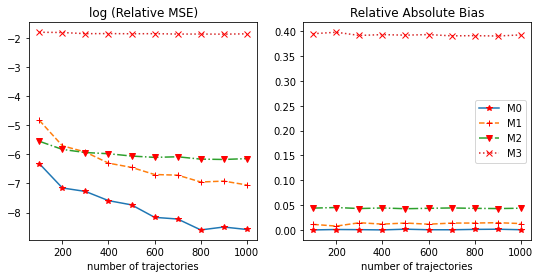

In [ ]:
import matplotlib.pyplot as plt
base = np.exp(1)
trajectory = [100,200,300,400,500,600,700,800,900,1000]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

#pyl.xlim(0, 20)
#pyl.ylim(0.25, 2)

ax1.plot(trajectory, np.log(MSE_pi0_MR_M0/eta_pi0_true**2) / np.log(base),marker='*', linestyle='-', mec='r', mfc='r', label='M0')
ax1.plot(trajectory, np.log(MSE_pi0_MR_M1/eta_pi0_true**2) / np.log(base),marker='+', linestyle='--', mec='r', mfc='r', label='M1')
ax1.plot(trajectory, np.log(MSE_pi0_MR_M2/eta_pi0_true**2) / np.log(base),marker='v', linestyle='-.', mec='r', mfc='r', label='M2')
ax1.plot(trajectory, np.log(MSE_pi0_MR_M3/eta_pi0_true**2) / np.log(base),marker='x', linestyle=':', mec='r', mfc='r', label='M3')
ax1.set_xlabel("number of trajectories")
ax1.set_title('log (Relative MSE)')

ax2.plot(trajectory, (abs(Bias_pi0_MR_M0/eta_pi0_true)) ,marker='*', linestyle='-', mec='r', mfc='r', label='M0')
ax2.plot(trajectory, (abs(Bias_pi0_MR_M1/eta_pi0_true)) ,marker='+', linestyle='--', mec='r', mfc='r', label='M1')
ax2.plot(trajectory, (abs(Bias_pi0_MR_M2/eta_pi0_true)) ,marker='v', linestyle='-.', mec='r', mfc='r', label='M2')
ax2.plot(trajectory, (abs(Bias_pi0_MR_M3/eta_pi0_true)) ,marker='x', linestyle=':', mec='r', mfc='r', label='M3')
ax2.set_xlabel("number of trajectories")
ax2.set_title('Relative Absolute Bias')
plt.legend(loc="best")
plt.show()